In [1]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 435, done.
remote: Counting objects: 100% (185/185), done.
remote: Compressing objects: 100% (101/101), done.
remote: Total 435 (delta 110), reused 84 (delta 80), pack-reused 250
Receiving objects: 100% (435/435), 70.49 MiB | 20.93 MiB/s, done.
Resolving deltas: 100% (204/204), done.
Checking out files: 100% (59/59), done.
Processing ./dul_2021
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for dul-2021: filename=dul_2021-0.1.0-py3-none-any.whl size=30522 sha256=cfa5bceb7985737fdb39f6e77d259483d56dd644e24d743064e8a1142206a3a4
  Stored in directory: /tmp/pip-ephem-wheel-cac

In [2]:
from dul_2021.utils.hw11_utils import *

# Question 1. BYOL

Here we will implement [BYOL](https://arxiv.org/abs/2006.07733).

* You can combine view, representation, and projection into one network. You can use same architechure as in practice. 

* Use BatchNorm

* As predictor use few linear layers

* Dataset comes untransformed, so you need to apply transformations during training by yourself. Use same augmentations as in SimCLR

**Hyperparameters**

* τ = 0.99 (target update coefficient)
* lr = 1e-4
* num_epochs = 20
* latent dim = 128



**You will provide the following deliverables**


1. Over the course of training, record loss ber batch.
2. A function that encodes a batch of images with your trained model. The function recieves a batch torch tensors on cpu and should return transformed 2d tensor (batch size x laten dim). It will be used to test representation on classification task.

In [3]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from itertools import chain
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import transforms
from tqdm.auto import trange, tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



def off_diagonal(x):
    n, m = x.shape
    assert n == m
    return x.flatten()[:-1].view(n - 1, n + 1)[:, 1:].flatten()


class Block(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1, lr_cf=0.3, ):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, (3, 3), stride=stride, padding=1)
        self.norm = nn.BatchNorm2d(out_ch)
        self.dropout = nn.Dropout(0.4)
        self.act = nn.LeakyReLU(lr_cf)

    def forward(self, x):
        return self.act(self.dropout(self.norm(self.conv(x))))


class ImageEncoder(nn.Module):
    def __init__(self, in_channels, latent_dim):
        super().__init__()

        self.blocks = nn.Sequential(
            Block(in_channels, 16, stride=2),
            Block(16, 32, stride=2),
            Block(32, 64, stride=2),
            Block(64, 128, stride=2),
            Block(128, 128, stride=2).conv,
        )
        self.linear = nn.Linear(128, latent_dim)

    def forward(self, images):
        convolved = self.blocks(images)
        return self.linear(convolved.view(images.shape[0], -1))


class Predictor(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, latent_dim),
            nn.BatchNorm1d(latent_dim),
            nn.LeakyReLU(),
            nn.Linear(latent_dim, latent_dim),
        )

    def forward(self, features):
        return self.net(features)


class BarlowTwins:
    def __init__(self, latent_dim, lmbda=0.01):
        self.encoder = ImageEncoder(3, latent_dim).to(device)
        self.projector = Predictor(latent_dim).to(device)

        self.transforms = transforms.Compose(
            [
                transforms.RandomHorizontalFlip(),
                transforms.RandomResizedCrop(size=32),
                transforms.GaussianBlur(kernel_size=9),
                transforms.RandomApply(
                    [transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1)], p=0.8
                ),
                transforms.RandomGrayscale(0.2),
                transforms.Normalize((0.5,), (0.5,)),
            ]
        )
        self.device = device
        self.lmbda = lmbda

    def step(self, y1, y2):
        z_a = self.projector(self.encoder(y1))
        z_b = self.projector(self.encoder(y2))
        bs, dim = z_a.shape
        z_a_norm = (z_a - z_a.mean(0)) / z_a.std(0)
        z_b_norm = (z_b - z_b.mean(0)) / z_b.std(0)

        c = torch.mm(z_a_norm.T, z_b_norm) / bs
        c_diff = (c - torch.eye(dim, device=self.device)).pow(2)
        c_diff *= self.lmbda
        torch.diagonal(c_diff).mul_(1.0 / self.lmbda)

        loss = c_diff.sum()
        return loss

    def fit(self, train_dataloader, lr=1e-4, n_epochs=5):
        optim = torch.optim.AdamW(chain(self.encoder.parameters(), self.projector.parameters()), lr=lr)
        losses = []
        self.encoder.train()
        self.projector.train()
        for e in range(n_epochs):
            is_last_epoch = e == n_epochs - 1
            train_tqdm_bar = tqdm(train_dataloader, desc="Training", leave=is_last_epoch)
            postfix = {}
            for batch in train_tqdm_bar:
                x = self.transforms(batch).to(self.device)
                y = self.transforms(batch).to(self.device)

                loss = self.step(x, y)
                optim.zero_grad()
                loss.backward()
                optim.step()

                losses.append(loss.item())
                postfix["loss"] = losses[-1]
                train_tqdm_bar.set_postfix(postfix)
            train_tqdm_bar.close()
        return losses

    def encode(self, x):
        self.encoder.eval()
        with torch.no_grad():
            x = x.to(self.device)
            return self.encoder(x).detach()


class BYOL:
    def __init__(self, latent_dim, m=0.99):
        self.student = ImageEncoder(1, latent_dim).to(device)

        self.teacher = ImageEncoder(1, latent_dim).to(device)
        for st_param, t_param in zip(self.student.parameters(), self.teacher.parameters()):
            t_param.data.copy_(st_param.data)
            t_param.requires_grad = False

        self.predictor = Predictor(latent_dim).to(device)

        self.transforms = transforms.Compose(
            [
                transforms.RandomHorizontalFlip(),
                transforms.RandomResizedCrop(size=28),
                transforms.RandomApply(
                    [transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1)], p=0.8
                ),
                transforms.GaussianBlur(kernel_size=9),
                transforms.Normalize((0.5,), (0.5,)),
            ]
        )

        self.device = device
        self.m = m

    def step(self, x, y):
        x = self.predictor(self.student(x))
        norm_x = F.normalize(x, dim=1)

        with torch.no_grad():
            y = self.teacher(y)
            norm_y = F.normalize(y, dim=1)

        loss = 2 - 2 * (norm_x * norm_y).sum(dim=-1)
        return loss

    def update_teacher(self):
        for st_param, t_param in zip(self.student.parameters(), self.teacher.parameters()):
            t_param.data = t_param.data * self.m + st_param.data * (1 - self.m)

    def fit(self, train_dataloader, lr=5e-4, n_epochs=5):
        optim = torch.optim.AdamW(
            chain(self.student.parameters(), self.predictor.parameters()), lr=lr, weight_decay=1e-4
        )
        losses = []
        self.student.train()
        self.predictor.train()
        for e in range(n_epochs):
            is_last_epoch = e == n_epochs - 1
            train_tqdm_bar = tqdm(train_dataloader, desc="Training", leave=is_last_epoch)
            postfix = {}
            for batch in train_tqdm_bar:
                x = self.transforms(batch).to(self.device)
                y = self.transforms(batch).to(self.device)

                loss = self.step(x, y) + self.step(y, x)
                loss = loss.mean()

                optim.zero_grad()
                loss.backward()
                optim.step()

                self.update_teacher()

                losses.append(loss.item())
                postfix["loss"] = losses[-1]
                train_tqdm_bar.set_postfix(postfix)
            train_tqdm_bar.close()
        return losses

    def encode(self, x):
        self.student.eval()
        with torch.no_grad():
            x = x.to(self.device)
            return self.student(x).detach()


In [4]:
class MNISTDataset(Dataset):
    def __init__(self, data):
        self.data = data
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx][0]

def q1(train_data):
    """
    train_data: An (n_train, 1, 28, 28) torchvision dataset of MNIST images with values from -1 to 1

    Returns
    - a (# of training iterations,) numpy array losses on each iteration
    - a function that transforms batch of images into their latent representation
    """
    train_dataset = MNISTDataset(train_data)
    train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)

    latent_dim = 128
    byol = BYOL(latent_dim)

    losses = byol.fit(train_dataloader, n_epochs=5)
    return losses, byol.encode

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

mean classification accuracy=0.7303


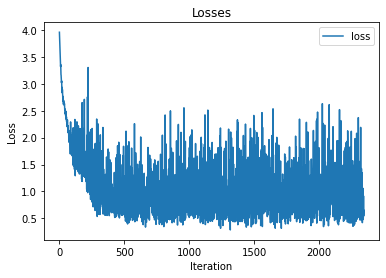

In [5]:
# change flag to False if you want only to test your losses w/o accuracy (it takes around 4-5 minutes)
q1_results(q1, True)

# Question 2. Barlow Twins

Here we will implement [barlow twins](https://arxiv.org/abs/2103.03230).

* You can use same architechure as in practice. 

* Dataset comes untransformed, so you need to apply transformations during training by yourself. Use same augmentations as in SimCLR

**Hyperparameters**

* λ = 0.01 
* lr = 5e-4
* num_epochs = 20
* latent dim = 128



**You will provide the following deliverables**


1. Over the course of training, record loss ber batch.
2. A function that encodes a batch of images with your trained model. The function recieves a batch torch tensors on cpu and should return transformed 2d tensor (batch size x laten dim). It will be used to test representation on classification task.

In [6]:
def q2(train_data, test_data):
    """
    train_data: An (n_train, 1, 32, 32) torchvision dataset of CIFAR10 images with values from -1 to 1

    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - a function that transforms batch of images into their latent representation
    """
    train_dataset = MNISTDataset(train_data)
    train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)

    latent_dim = 128
    barlow_twins = BarlowTwins(latent_dim)

    losses = barlow_twins.fit(train_dataloader, n_epochs=5)
    return losses, barlow_twins.encode

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Training:   0%|          | 0/391 [00:00<?, ?it/s]

Training:   0%|          | 0/391 [00:00<?, ?it/s]

Training:   0%|          | 0/391 [00:00<?, ?it/s]

Training:   0%|          | 0/391 [00:00<?, ?it/s]

mean classification accuracy=0.3369


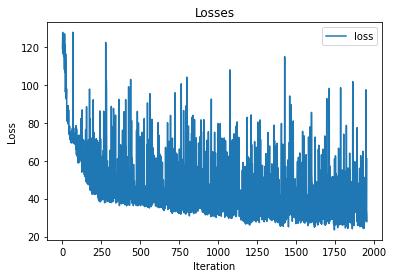

In [7]:
# change flag to False if you want only to test your losses w/o accuracy (it takes around 4-5 minutes)
q2_results(q2, True)

# Bonus. SwAV

Here we will implement [SwAV](https://arxiv.org/abs/2006.09882v5)

**You will provide the following deliverables**


1. Over the course of training, record loss ber batch.
2. A function that encodes a batch of images with your trained model. The function recieves a batch torch tensors on cpu and should return transformed 2d tensor (batch size x laten dim). It will be used to test representation on classification task.

In [8]:
def b(train_data):
    """
    train_data: An (n_train, 1, 32, 32) torchvision dataset of CIFAR10 images with values from -1 to 1

    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - a function that transforms batch of images into their latent representation
    """

In [9]:
q2_results(b, True)

Files already downloaded and verified
Files already downloaded and verified


TypeError: ignored